<a href="https://colab.research.google.com/github/peacelovr/9517-GroupWork/blob/main/9517_esnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Using device: cuda
Total samples in dataset: 12010
Classes: ['Agriculture', 'Airport', 'Beach', 'City', 'Desert', 'Forest', 'Grassland', 'Highway', 'Lake', 'Mountain', 'Parking', 'Port', 'Railway', 'Residential', 'River']
Train samples: 9608 Test samples: 2402
Epoch [1/100] Train Loss: 2.1251, Train Acc: 0.2833 | Test Loss: 1.6709, Test Acc: 0.4596
Epoch [2/100] Train Loss: 1.5476, Train Acc: 0.4830 | Test Loss: 1.4551, Test Acc: 0.5004
Epoch [3/100] Train Loss: 1.3267, Train Acc: 0.5576 | Test Loss: 1.1790, Test Acc: 0.5941
Epoch [4/100] Train Loss: 1.1967, Train Acc: 0.5969 | Test Loss: 1.1622, Test Acc: 0.6091
Epoch [5/100] Train Loss: 1.0980, Train Acc: 0.6336 | Test Loss: 1.0063, Test Acc: 0.6661
Epoch [6/100] Train Loss: 0.9998, Train Acc: 0.6730 | Test Loss: 1.0417, Test Acc: 0.6532
Epoch [7/100] Train Loss: 0.9310, Train Acc: 0.6877 | Test Loss: 1.061

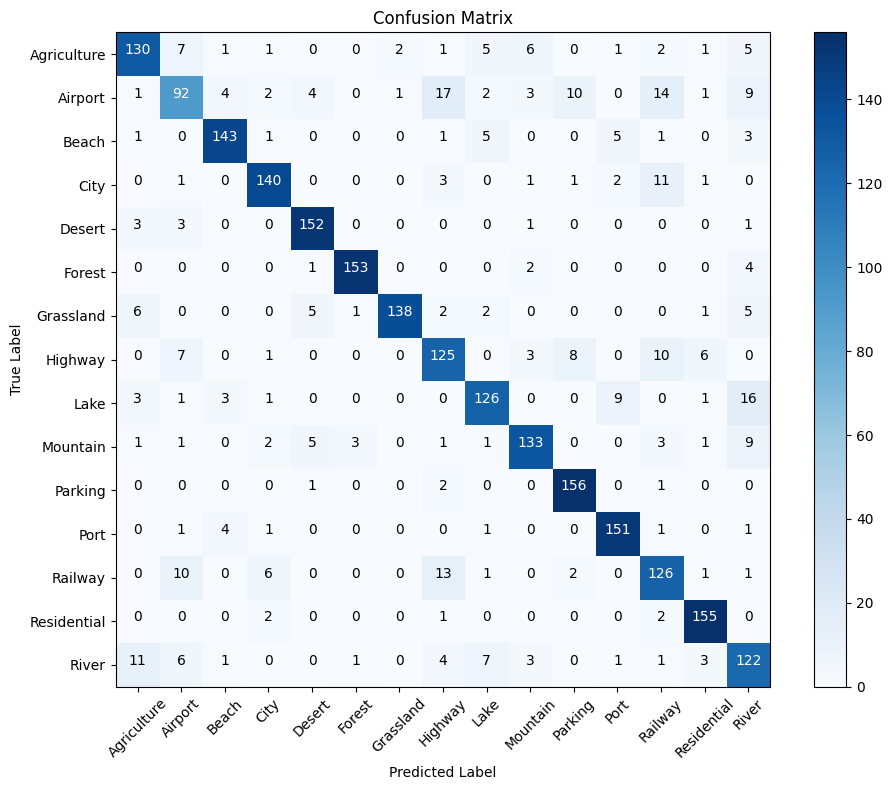

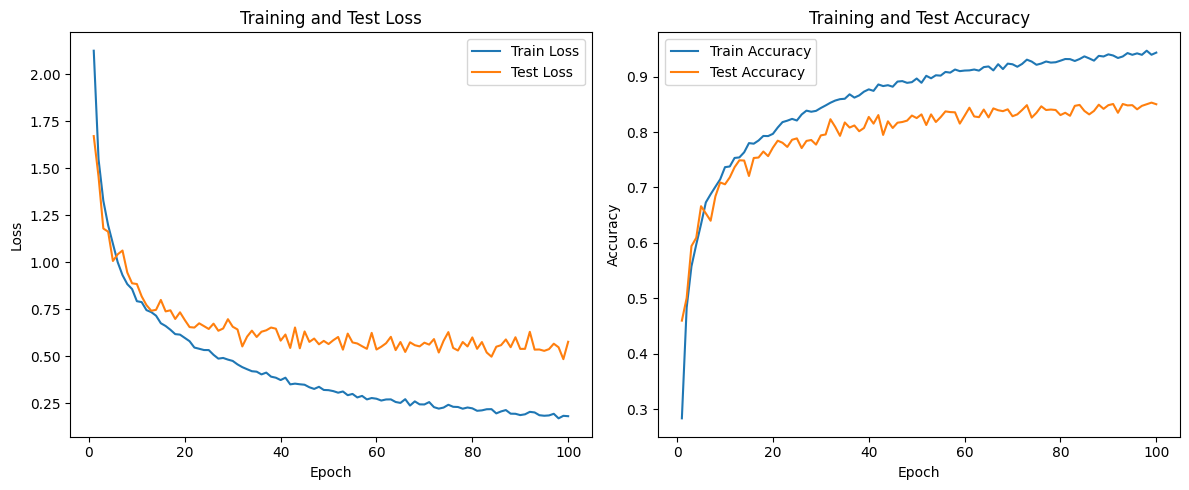

In [ ]:
# =====================================
# Step 0: 挂载 Google Drive
# =====================================
from google.colab import drive
drive.mount('/content/drive')

import os

# =====================================
# Step 1: 导入所需库
# =====================================
!pip install torch torchvision --quiet

import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
import copy

from torch.utils.data import DataLoader, Subset
from torchvision import transforms, datasets
from torchvision.models import vit_b_16, ViT_B_16_Weights

from sklearn.model_selection import train_test_split
from sklearn.metrics import (classification_report, confusion_matrix,
                             precision_recall_fscore_support, accuracy_score)

# =====================================
# Step 2: 设置数据集路径 & 训练参数
# =====================================
# 注意：这是你在 Google Drive 中的数据路径，请根据实际情况修改
data_dir = "/content/drive/MyDrive/9517 gp/Aerial_Landscapes"

# 是否使用GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# 超参数
batch_size = 32
num_epochs = 100
learning_rate = 1e-3
test_split = 0.2  # 80% 训练 / 20% 测试
random_seed = 42  # 随机种子

# =====================================
# Step 3: 加载数据集 & 图像预处理
# =====================================
# 训练数据增广 & 测试数据变换
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

# 利用 ImageFolder 加载图像数据（文件夹名即类别名）
full_dataset = datasets.ImageFolder(root=data_dir)
print("Total samples in dataset:", len(full_dataset))
print("Classes:", full_dataset.classes)

# 按照 80-20 的比例分割：训练集 / 测试集（分层抽样保证各类比例）
indices = np.arange(len(full_dataset))
targets = np.array(full_dataset.targets)
train_idx, test_idx = train_test_split(
    indices, test_size=test_split, stratify=targets, random_state=random_seed
)
print("Train samples:", len(train_idx), "Test samples:", len(test_idx))

# 根据不同的 transform，制作训练集和测试集
train_dataset = copy.deepcopy(full_dataset)
train_dataset.transform = train_transform

test_dataset = copy.deepcopy(full_dataset)
test_dataset.transform = test_transform

train_subset = Subset(train_dataset, train_idx)
test_subset = Subset(test_dataset, test_idx)

# DataLoaders
train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True, num_workers=2)
test_loader = DataLoader(test_subset, batch_size=batch_size, shuffle=False, num_workers=2)

# =====================================
# Step 4: 构建 ViT 模型
# =====================================
# 使用 torchvision 提供的 vit_b_16 预训练权重
weights = ViT_B_16_Weights.IMAGENET1K_V1
model = vit_b_16(weights=weights)

# 获取原分类层(Sequential)中第2个模块(Linear)的 in_features
num_features = model.heads[0].in_features
# 替换为新的线性层，让输出类别数与数据集一致
model.heads[0] = nn.Linear(num_features, len(full_dataset.classes))

model = model.to(device)

# 定义损失函数和优化器
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# =====================================
# Step 5: 训练与验证循环
# =====================================
train_losses, train_accuracies = [], []
test_losses, test_accuracies = [], []

for epoch in range(num_epochs):
    # ---------- 训练 ----------
    model.train()
    running_loss, correct, total = 0.0, 0, 0

    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    epoch_loss = running_loss / total
    epoch_acc = correct / total
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_acc)

    # ---------- 测试 ----------
    model.eval()
    test_loss, test_correct, test_total = 0.0, 0, 0

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item() * inputs.size(0)
            _, predicted = outputs.max(1)
            test_total += labels.size(0)
            test_correct += predicted.eq(labels).sum().item()

    epoch_test_loss = test_loss / test_total
    epoch_test_acc = test_correct / test_total
    test_losses.append(epoch_test_loss)
    test_accuracies.append(epoch_test_acc)

    print(f"Epoch [{epoch+1}/{num_epochs}] "
          f"Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.4f} | "
          f"Test Loss: {epoch_test_loss:.4f}, Test Acc: {epoch_test_acc:.4f}")

# =====================================
# Step 6: 最终评估 & 指标输出
# =====================================
model.eval()
all_preds, all_labels = [], []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.numpy())

# Overall Accuracy
accuracy_val = accuracy_score(all_labels, all_preds)
# Macro Precision, Recall, F1
precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average='macro')

print("\n=== Test Evaluation Metrics ===")
print(f"Accuracy: {accuracy_val:.4f}")
print(f"Precision (Macro): {precision:.4f}")
print(f"Recall (Macro): {recall:.4f}")
print(f"F1-Score (Macro): {f1:.4f}")

print("\n=== Classification Report ===")
print(classification_report(all_labels, all_preds, target_names=full_dataset.classes))

# =====================================
# Step 7: 混淆矩阵可视化
# =====================================
cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(10,8))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.colorbar()

tick_marks = np.arange(len(full_dataset.classes))
plt.xticks(tick_marks, full_dataset.classes, rotation=45)
plt.yticks(tick_marks, full_dataset.classes)

plt.xlabel("Predicted Label")
plt.ylabel("True Label")

# 在混淆矩阵上打印数字
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
plt.tight_layout()
plt.show()

# =====================================
# Step 8: 绘制 Training History (Loss & Accuracy)
# =====================================
epochs_range = range(1, num_epochs+1)

plt.figure(figsize=(12,5))

# Loss 曲线
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_losses, label="Train Loss")
plt.plot(epochs_range, test_losses, label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Test Loss")
plt.legend()

# Accuracy 曲线
plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_accuracies, label="Train Accuracy")
plt.plot(epochs_range, test_accuracies, label="Test Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training and Test Accuracy")
plt.legend()

plt.tight_layout()
plt.show()
